In [1]:
%matplotlib inline

import pymongo
import seaborn as sns

In [2]:
ALGO = "STR_PCPTRN_RE-RANKER"
cb_td, cb_vd=  "CB_" + ALGO + "_FEATURE_SEL_TD", "CB_" + ALGO + "_FEATURE_SEL_VD"
# set to be the same for now
sc_td, sc_vd = "SC_" + ALGO + "_FEATURE_SEL_TD", "SC_" + ALGO + "_FEATURE_SEL_VD"

In [3]:
import pandas as pd

def group_by(df, bycols, agg_map):
    """
    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [4]:
client = pymongo.MongoClient()
db = client.metrics_causal_model_reranker

cb_td, cb_vd = db[cb_td], db[cb_vd]
sc_td, sc_vd = db[sc_td], db[sc_vd]

cb_td, cb_vd , sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'CB_STR_PCPTRN_RE-RANKER_FEATURE_SEL_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'CB_STR_PCPTRN_RE-RANKER_FEATURE_SEL_VD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'SC_STR_PCPTRN_RE-RANKER_FEATURE_SEL_TD'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_causal_model_reranker'), 'SC_STR_PCPTRN_RE-RANKER_FEATURE_SEL_VD'))

# Query Top Features

In [5]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score":  "$MICRO_F1.f1_score",
            "micro_recall":    "$MICRO_F1.recall",
            "micro_precision": "$MICRO_F1.precision",
            #"stemmed":        "$parameters.stemmed",
            "num_feats":      "$parameters.num_feats_MEAN",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

print(len(cb_td_rows), len(cb_vd_rows), len(sc_td_rows), len(sc_vd_rows))

40 40 40 40


In [6]:
def hash_feats(fts):
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

cb_vd_df.head(3)

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,num_feats,weighted_f1_score,hs_feats
0,5d102e8ce116f51cf6a4dc64,2019-06-23 20:59:40.503,2,"[Prob-, Above-]",0.740483,0.786858,0.699270,33.0,0.0,Above-|Prob-
1,5d102d30e116f51cf6a4dc5a,2019-06-23 20:53:52.594,2,"[Prob-, Inv-]",0.739394,0.768504,0.712409,16.0,0.0,Inv-|Prob-
2,5d3e5c189d1fa2f284b629b1,2019-07-28 21:38:16.579,5,"[Prob-, Above-, Propn_, Inv-, Diff_]",0.738617,0.787278,0.695620,45.0,0.0,Above-|Diff_|Inv-|Prob-|Propn_


In [7]:
min(cb_vd_df["asof"].values),max(cb_vd_df["asof"].values)

(numpy.datetime64('2019-06-23T20:45:54.660000000'),
 numpy.datetime64('2019-07-28T21:38:16.579000000'))

In [8]:
# Causal Relation Confidence
# Causal Relation Types
prefix2name = {
    "Prob-":     "Probability Stats." ,
    "Inv-":      "Inverted Causal Rels.",
    "num_crels": "Number Causal Rels.",
    "Tally-":    "Concept Code Frequency",
    "CChain-":   "Causal Chains",
    "CChainStats-": "Causal Chain Stats.",
    "Above-":    "Causal Rel. Conf.",
    "CREL_":     "Causal Rels. Frequency",
    "Propn_":    "Causal Rel. Types",
    "Diff_":     "Causal Rel Span Stats"
}

In [9]:
cols = "feats,count,micro_f1_score,micro_recall,micro_precision".split(",")
sc_cols = "feats,count,micro_f1_score,micro_recall,micro_precision,num_feats".split(",")

def code_name_2_descriptive_name(ft):
    ft = ft.strip()
    if ft in prefix2name:
        return prefix2name[ft]
    return ft

def feat_name(ft):
    if type(ft) == list:
        ft=",".join(map(code_name_2_descriptive_name,ft))
    else:
        ft = code_name_2_descriptive_name(ft)

#     offset = (11-1)/2
#     offset_lbl = "offset:%i" % offset
#     ft=ft.replace(offset_lbl, "").replace("fn_", "").replace(" ","")

    return ft

def get_top_individual_feats(df, cols=cols):
    df_top_individual_feats = df[(df["count"] == 1)][cols]
    df_top_individual_feats["rank"] = np.arange(len(df_top_individual_feats)) + 1
    df_top_individual_feats["feats"] = df_top_individual_feats["feats"].apply(feat_name)
    return df_top_individual_feats

#get_top_individual_feats(cb_vd_df, False)

### Performance of Each Feature In Isolation

In [11]:
import numpy as np
stemmed = True
a, b = get_top_individual_feats(cb_vd_df), get_top_individual_feats(sc_vd_df, sc_cols)
merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])\
["rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC,num_feats".split(",")]

merged["num_feats_SC"] = merged["num_feats"]
del merged["num_feats"]
merged

,rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC,num_feats_SC
0,1,Probability Stats.,0.737605,0.705839,0.772364,Causal Rel. Conf.,0.809840,0.772255,0.851272,21.0
1,2,Causal Rel. Conf.,0.733841,0.685766,0.789164,Probability Stats.,0.803292,0.755009,0.858172,12.0
2,3,Concept Code Frequency,0.731736,0.690876,0.777732,Causal Rels. Frequency,0.798436,0.750951,0.852332,1636.8
3,4,Number Causal Rels.,0.731349,0.708394,0.755841,Concept Code Frequency,0.789541,0.781131,0.798134,27.0
4,5,Causal Rels. Frequency,0.729187,0.669708,0.800262,Number Causal Rels.,0.672472,0.656099,0.689683,34.8
5,6,Causal Rel Span Stats,0.635851,0.534672,0.784261,Causal Rel. Types,0.670684,0.564545,0.825974,4.0
6,7,Causal Rel. Types,0.633727,0.538321,0.770235,Causal Rel Span Stats,0.629101,0.542227,0.749124,4.0
7,8,Causal Chain Stats.,0.624415,0.535766,0.748216,Causal Chain Stats.,0.622785,0.530307,0.754329,28.8
8,9,Causal Chains,0.339151,0.212774,0.835244,Causal Chains,0.613051,0.476541,0.859168,587.4
9,10,Inverted Causal Rels.,0.000000,0.000000,0.000000,Inverted Causal Rels.,0.446486,0.332742,0.678387,4.0


In [12]:
merged2=merged[["rank","feats_CB", "micro_f1_score_CB", #"num_feats_CB",
                "feats_SC", "micro_f1_score_SC", "num_feats_SC"]].copy()
for c in merged2.columns:
    if "micro" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:.3f}".format(d) if type(d) == float else d)
    elif "num" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:,.1f}".format(d) if type(d) == float else d)
merged2

,rank,feats_CB,micro_f1_score_CB,feats_SC,micro_f1_score_SC,num_feats_SC
0,1,Probability Stats.,0.738,Causal Rel. Conf.,0.810,21.0
1,2,Causal Rel. Conf.,0.734,Probability Stats.,0.803,12.0
2,3,Concept Code Frequency,0.732,Causal Rels. Frequency,0.798,"1,636.8"
3,4,Number Causal Rels.,0.731,Concept Code Frequency,0.790,27.0
4,5,Causal Rels. Frequency,0.729,Number Causal Rels.,0.672,34.8
5,6,Causal Rel Span Stats,0.636,Causal Rel. Types,0.671,4.0
6,7,Causal Rel. Types,0.634,Causal Rel Span Stats,0.629,4.0
7,8,Causal Chain Stats.,0.624,Causal Chain Stats.,0.623,28.8
8,9,Causal Chains,0.339,Causal Chains,0.613,587.4
9,10,Inverted Causal Rels.,0.000,Inverted Causal Rels.,0.446,4.0


## Generate Rows for LaTex Table

In [13]:
def format_lbl(lbl):
    lbl = str(lbl)
    return lbl.replace("["," ").replace("]","").replace("_"," ").strip()

In [14]:
max_cb = max(merged.micro_f1_score_CB)
max_sc = max(merged.micro_f1_score_SC)
max_cb, max_sc

(0.7376048817696416, 0.8098404255319149)

In [15]:
for i, row in merged.iterrows():
    feats_CB = format_lbl(row["feats_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]    
    # {cb_f1:0.3f}
    
    feats_SC = format_lbl(row["feats_SC"])
    micro_f1_score_SC = row["micro_f1_score_SC"]
    
    print("{rank} & {feat_cb} & {cb_f1:0.3f} & & {feat_sc} & {sc_f1:0.3f}\\\\"\
          .format(rank=i+1,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))


1 & Probability Stats. & 0.738 & & Causal Rel. Conf. & 0.810\\
2 & Causal Rel. Conf. & 0.734 & & Probability Stats. & 0.803\\
3 & Concept Code Frequency & 0.732 & & Causal Rels. Frequency & 0.798\\
4 & Number Causal Rels. & 0.731 & & Concept Code Frequency & 0.790\\
5 & Causal Rels. Frequency & 0.729 & & Number Causal Rels. & 0.672\\
6 & Causal Rel Span Stats & 0.636 & & Causal Rel. Types & 0.671\\
7 & Causal Rel. Types & 0.634 & & Causal Rel Span Stats & 0.629\\
8 & Causal Chain Stats. & 0.624 & & Causal Chain Stats. & 0.623\\
9 & Causal Chains & 0.339 & & Causal Chains & 0.613\\
10 & Inverted Causal Rels. & 0.000 & & Inverted Causal Rels. & 0.446\\


## Performance By Feature Set Size

In [16]:
def get_by_featureset_size(df):
    return group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              ("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")

pd.merge(get_by_featureset_size(cb_vd_df), get_by_featureset_size(sc_vd_df), on="count", how="outer", suffixes=["_cb", "_sc"])

,count,max(micro_f1_score)_cb,mean(micro_f1_score)_cb,max(micro_f1_score)_sc,mean(micro_f1_score)_sc
0,1,0.737605,0.589686,0.809840,0.685569
1,2,0.740483,0.729602,0.810370,0.808384
2,3,0.738169,0.735556,0.810746,0.808585
3,4,0.738354,0.734458,0.811784,0.809996
4,5,0.738617,0.735387,0.811316,0.809205


# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [17]:
# cols_filter = "count,new_feat,micro_f1_score,num_feats".split(",")
cols_filter = "count,new_feat,micro_f1_score".split(",")

def get_f1_by_feat_count(df):
#     df=df[df["stemmed"] == True]
    top_feats = df[df["count"] == df["count"].max()]
    top_feats = top_feats.sort_values("micro_f1_score", ascending=False).iloc[0]["feats"]
    
    rows = []
    for i in range(0,len(top_feats)):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)
        new_row = df[df["hs_feats"] == hs].iloc[0]
        new_row["new_feat"] = feat_name(new_feat)
        copy = {}
        for k in new_row.keys():
            copy[str(k).strip()] = new_row[k]
        rows.append(copy)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

df_f1_score_by_feat_size= pd.merge(
    get_f1_by_feat_count(cb_vd_df), get_f1_by_feat_count(sc_vd_df), on="count", 
    how="outer", suffixes=("_CB", "_SC"))

## df_f1_score_by_feat_size
#  Note that the optimal feature set for SC is only of size 4

#get_f1_by_feat_count(cb_vd_df)
#get_f1_by_feat_count(sc_vd_df)

df_f1_score_by_feat_size

,count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC
0,1,Probability Stats.,0.737605,Causal Rel. Conf.,0.809840
1,2,Causal Rel. Conf.,0.740483,Inverted Causal Rels.,0.810370
2,3,Causal Rel. Types,0.738169,Number Causal Rels.,0.810746
3,4,Inverted Causal Rels.,0.738354,Causal Chain Stats.,0.811784
4,5,Causal Rel Span Stats,0.738617,Causal Rel Span Stats,0.811316


In [18]:
# Round to 4 d.p. for printing
df = df_f1_score_by_feat_size["count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC".split(",")].copy()
df["micro_f1_score_CB"] = df["micro_f1_score_CB"].apply(lambda d: "{0:.4f}".format(d))
# df["num_feats_CB"]      = df["num_feats_CB"].apply(lambda d: "{0:,.1f}".format(d))
df["micro_f1_score_SC"] = df["micro_f1_score_SC"].apply(lambda d: "{0:.4f}".format(d))  
# df["num_feats_SC"]      = df["num_feats_SC"].apply(lambda d: "{0:,.1f}".format(d))
df

,count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC
0,1,Probability Stats.,0.7376,Causal Rel. Conf.,0.8098
1,2,Causal Rel. Conf.,0.7405,Inverted Causal Rels.,0.8104
2,3,Causal Rel. Types,0.7382,Number Causal Rels.,0.8107
3,4,Inverted Causal Rels.,0.7384,Causal Chain Stats.,0.8118
4,5,Causal Rel Span Stats,0.7386,Causal Rel Span Stats,0.8113


# Plot F1 Score Against # Feature Sets

### Get the Max F1 Score for Each Size of Feature Set (Win = 9)

In [19]:
def get_max_f1_by_feat_count(df):
    max_feats = df["count"].values.max()
    rows = []
    for cnt in range(1, max_feats+1):
        
        row = df[df["count"] == cnt].sort_values("micro_f1_score", ascending=False).iloc[0]        
        rows.append(row)

    return pd.DataFrame(rows)

In [20]:
df_cb = get_max_f1_by_feat_count(cb_vd_df)[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
df_sc = get_max_f1_by_feat_count(sc_vd_df)[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
by_feat_size = pd.merge(df_cb, df_sc, on="count", how="outer", suffixes=["_CB", "_SC"])
by_feat_size

,count,feats_CB,micro_f1_score_CB,micro_precision_CB,micro_recall_CB,feats_SC,micro_f1_score_SC,micro_precision_SC,micro_recall_SC
0,1,[Prob-],0.737605,0.772364,0.705839,[Above-],0.809840,0.851272,0.772255
1,2,"[Prob-, Above-]",0.740483,0.786858,0.699270,"[Above-, Inv-]",0.810370,0.856497,0.768958
2,3,"[Prob-, Above-, Propn_]",0.738169,0.787666,0.694526,"[Above-, Inv-, num_crels]",0.810746,0.857022,0.769211
3,4,"[Prob-, Above-, Propn_, Inv-]",0.738354,0.788557,0.694161,"[Above-, Inv-, num_crels, CChainStats-]",0.811784,0.855577,0.772255
4,5,"[Prob-, Above-, Propn_, Inv-, Diff_]",0.738617,0.787278,0.695620,"[Above-, Inv-, num_crels, CChainStats-, Diff_]",0.811316,0.856097,0.770987


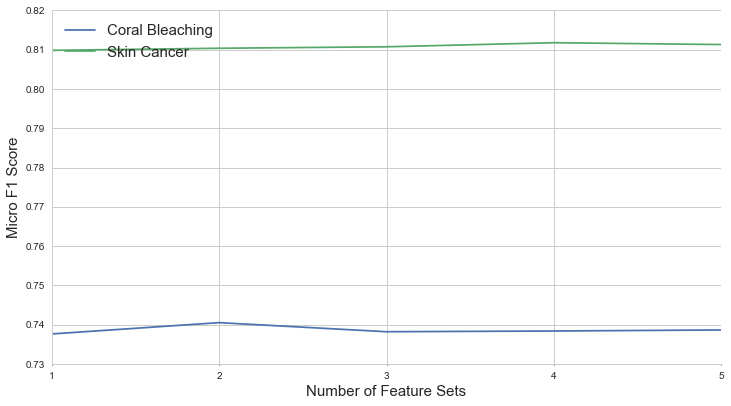

In [21]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 15

df = by_feat_size

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(12,6.5))

x = df["count"].values
y_cb = df["micro_f1_score_CB"].values
y_sc = df["micro_f1_score_SC"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_cb, label="Coral Bleaching")
ax1.plot(x,y_sc, label="Skin Cancer")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 5])
ax1.set_ylim([0.73, 0.82])
ax1.set_xlabel('Number of Feature Sets', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=10)
sns.despine()

plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/re-ranker_f1_score_by_num_feats.png")
plt.show()

## Generate Rows for LaTex Table

### F1 Score As Individual Features are Added

In [22]:
max_cb = max(df_f1_score_by_feat_size.micro_f1_score_CB)
max_sc = max(df_f1_score_by_feat_size.micro_f1_score_SC)
max_cb, max_sc

(0.7404830917874395, 0.8117835243934951)

In [23]:
for i, row in df_f1_score_by_feat_size.iterrows():
    #pprint(row)
    
    feats_CB = format_lbl(str(row["new_feat_CB"]))
    if feats_CB == "nan":
        feats_CB = "-"
        
    micro_f1_score_CB = row["micro_f1_score_CB"]
    if str(micro_f1_score_CB) != "nan":
        if micro_f1_score_CB == max_cb:
            micro_f1_score_CB = "\\textbf{{ {0:0.4f} }}".format(micro_f1_score_CB)
        else:
            micro_f1_score_CB = "{0:0.4f}".format(micro_f1_score_CB)
    else:
        micro_f1_score_CB = "-"
    
    feats_SC = format_lbl(str(row["new_feat_SC"]))
    if feats_SC == "nan":
        feats_SC = "-"
        
    micro_f1_score_SC = row["micro_f1_score_SC"]
    if str(micro_f1_score_SC) != "nan":
        if micro_f1_score_SC == max_sc:
            micro_f1_score_SC = "\\textbf{{ {0:0.4f} }}".format(micro_f1_score_SC)
        else:
            micro_f1_score_SC = "{0:0.4f}".format(micro_f1_score_SC)
    else:
        micro_f1_score_SC = "-"
    
    count = row["count"]
    print("{count} & {feat_cb} & {cb_f1} & & {feat_sc} & {sc_f1}\\\\"\
          .format(count=count,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))

1 & Probability Stats. & 0.7376 & & Causal Rel. Conf. & 0.8098\\
2 & Causal Rel. Conf. & \textbf{ 0.7405 } & & Inverted Causal Rels. & 0.8104\\
3 & Causal Rel. Types & 0.7382 & & Number Causal Rels. & 0.8107\\
4 & Inverted Causal Rels. & 0.7384 & & Causal Chain Stats. & \textbf{ 0.8118 }\\
5 & Causal Rel Span Stats & 0.7386 & & Causal Rel Span Stats & 0.8113\\


## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [24]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"

## Feature Reduction

#### CB

In [30]:
# Note - query CB_RE-RANKER_FEATURE_SEL_VD_MAX_FT_CNTS to get the max feature counts

# cb_vd_df[cb_vd_df.num_feats == max(cb_vd_df.num_feats)] - this is not max feats however
cb_vd_df.head(3) # get num feats for the top model

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,num_feats,weighted_f1_score,hs_feats
0,5d102e8ce116f51cf6a4dc64,2019-06-23 20:59:40.503,2,"[Prob-, Above-]",0.740483,0.786858,0.699270,33.0,0.0,Above-|Prob-
1,5d102d30e116f51cf6a4dc5a,2019-06-23 20:53:52.594,2,"[Prob-, Inv-]",0.739394,0.768504,0.712409,16.0,0.0,Inv-|Prob-
2,5d3e5c189d1fa2f284b629b1,2019-07-28 21:38:16.579,5,"[Prob-, Above-, Propn_, Inv-, Diff_]",0.738617,0.787278,0.695620,45.0,0.0,Above-|Diff_|Inv-|Prob-|Propn_


In [33]:
100 * (1 - 33 / 1698.8)

98.0574523192842

#### SC

In [31]:
# for max feats, query - SC_RE-RANKER_FEATURE_SEL_VD_MAX_FT_CNTS
sc_vd_df.head(3)

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,num_feats,weighted_f1_score,hs_feats
0,5d2005549d1fa24c24f3c8a8,2019-07-05 21:20:04.461,4,"[Above-, Inv-, num_crels, CChainStats-]",0.811784,0.855577,0.772255,88.6,0.0,Above-|CChainStats-|Inv-|num_crels
1,5d1ffffa9d1fa24c24f3c8a2,2019-07-05 20:57:14.996,4,"[Above-, Inv-, num_crels, Prob-]",0.811474,0.856137,0.771240,71.8,0.0,Above-|Inv-|Prob-|num_crels
2,5d2019a09d1fa24c24f3c8ba,2019-07-05 22:46:40.540,5,"[Above-, Inv-, num_crels, CChainStats-, Diff_]",0.811316,0.856097,0.770987,92.6,0.0,Above-|CChainStats-|Diff_|Inv-|num_crels
